In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [2]:
# import cleaned users file
users = pd.read_csv('takehome_users_cleaned.csv',parse_dates=['creation_time'],index_col='object_id')
users.drop('Unnamed: 0',axis=1,inplace = True)

### EDA 

In [3]:
#sns.pairplot(users)

In [4]:
users.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,creation_week,creation_day,invited_by_user
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,141.884583,3188.691333,0.135917,2013.060833,6.250833,25.360000,15.986583,0.534750
std,0.432742,0.356432,124.056723,3869.027693,0.342714,0.723424,3.423968,14.871343,8.803533,0.498812
min,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,29.000000,0.000000,0.000000,2013.000000,3.000000,13.000000,8.000000,0.000000
50%,0.000000,0.000000,108.000000,875.000000,0.000000,2013.000000,6.000000,23.000000,16.000000,1.000000
75%,0.000000,0.000000,238.250000,6317.000000,0.000000,2014.000000,9.000000,38.000000,24.000000,1.000000
max,1.000000,1.000000,416.000000,11999.000000,1.000000,2014.000000,12.000000,52.000000,31.000000,1.000000


In [5]:
print("The percentage of adopted users is: {}".format(round(len(users[users.adopted == 1])/len(users),2)))

The percentage of adopted users is: 0.14


In [6]:
len(users[users.adopted == 1])

1631

In [7]:
# subset adopted users
adopted = users[users.adopted == 1] 

In [8]:
len(adopted)

1631

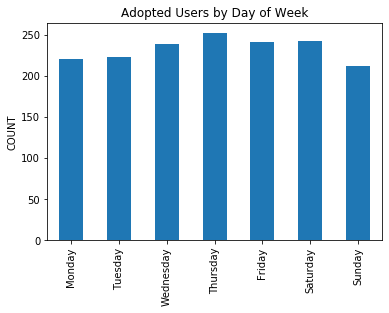

In [9]:
# users by adoption day of week/month
adopted['creation_time'].dt.dayofweek.value_counts().sort_index().plot(kind='bar')
_ = plt.title('Adopted Users by Day of Week')
_ = plt.ylabel('COUNT')
_ = plt.xticks(np.arange(7),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [10]:
# adopted by mailing list join
adopted.groupby(['enabled_for_marketing_drip'])['adopted'].count()

enabled_for_marketing_drip
0    1380
1     251
Name: adopted, dtype: int64

In [11]:
adopted.groupby(['opted_in_to_mailing_list'])['adopted'].sum()

opted_in_to_mailing_list
0    1212
1     419
Name: adopted, dtype: int64

In [12]:
adopted.groupby(['invited_by_user_id'])['adopted'].sum().nlargest()

invited_by_user_id
0.0        696
2354.0       4
10628.0      4
730.0        3
879.0        3
Name: adopted, dtype: int64

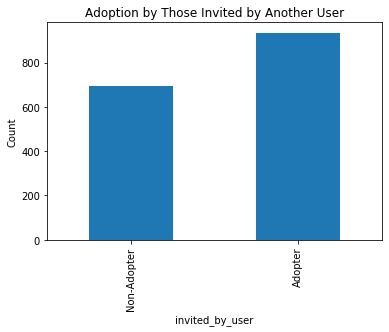

In [13]:
_ = adopted.groupby(['invited_by_user'])['adopted'].sum().plot(kind='bar')
_ = plt.xticks([0, 1], ['Non-Adopter', 'Adopter'])
_ = plt.ylabel('Count')
_ = plt.title('Adoption by Those Invited by Another User')

It appears like user 0 has made a number of recommendations; however, this was the filled value that we used, meaning that there was no recommendation given.

In [14]:
adopted.groupby(['org_id'])['adopted'].sum().nlargest(20)

org_id
1     17
7     17
4     15
0     14
2     14
9     14
3     13
13    13
5     12
24    12
62    12
58    11
8     10
10    10
20    10
44    10
6      9
31     9
33     9
34     9
Name: adopted, dtype: int64

In [15]:
adopted.groupby(['creation_source'])['adopted',].sum()

,adopted
creation_source,
GUEST_INVITE,363
ORG_INVITE,572
PERSONAL_PROJECTS,168
SIGNUP,294
SIGNUP_GOOGLE_AUTH,234


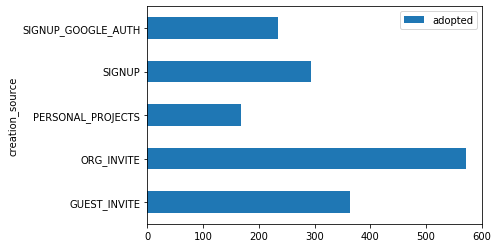

In [16]:
adopted.groupby(['creation_source'])['adopted',].sum().plot(kind='barh')

In [17]:
adopted.groupby(['creation_week'])['adopted'].sum().nlargest(10)

creation_week
47    44
11    43
3     42
44    42
37    41
6     40
24    40
32    40
12    39
1     38
Name: adopted, dtype: int64

In [18]:
adopted.groupby(['creation_month'])['adopted'].sum()

creation_month
1     151
2     140
3     164
4     108
5      66
6     150
7     119
8     145
9     141
10    163
11    151
12    133
Name: adopted, dtype: int64

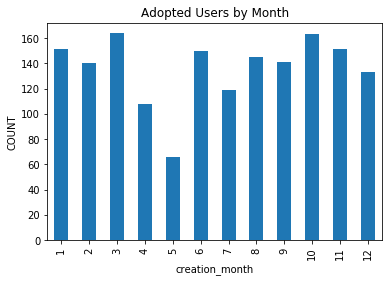

In [19]:
adopted.groupby(['creation_month'])['adopted'].sum().plot(kind='bar')
_ = plt.title('Adopted Users by Month')
_ = plt.ylabel('COUNT')

### MODELING:  Random Forest Classifier

Model 1: Without DateTime Features

In [20]:
users = pd.get_dummies(users)
users.head()

,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,creation_week,creation_day,invited_by_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,1,0,11,10803.0,0,2014,4,17,22,1,1,0,0,0,0
2,2013-11-15 03:45:04,0,0,1,316.0,1,2013,11,46,15,1,0,1,0,0,0
3,2013-03-19 23:14:52,0,0,94,1525.0,0,2013,3,12,19,1,0,1,0,0,0
4,2013-05-21 08:09:28,0,0,1,5151.0,0,2013,5,21,21,1,1,0,0,0,0
5,2013-01-17 10:14:20,0,0,193,5240.0,0,2013,1,3,17,1,1,0,0,0,0


In [21]:
X = users.drop(['adopted','creation_time','creation_day','creation_year','creation_month','creation_week'],axis=1)
y = users.adopted

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

rf1 = RandomForestClassifier(n_estimators = 300, random_state = 42)

rf1.fit(X_train,y_train)
y_pred = rf1.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8152777777777778


In [23]:
def feat_importance(randomforest,X_train):
    importance = randomforest.feature_importances_
    importance = pd.DataFrame(importance,index=X_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

# call function on new model and training data
importance = feat_importance(rf1,X_train)
importance["Cumul_Imp"] = np.cumsum(importance.Importance)
importance[:4]

,Importance,Cumul_Imp
org_id,0.617056,0.617056
invited_by_user_id,0.342020,0.959075
opted_in_to_mailing_list,0.012389,0.971464
enabled_for_marketing_drip,0.010724,0.982189


Model 2: With DateTime Features

In [24]:
# also remove invited_by_user_id, based on results above -- the filled in 0s may be skewing the model
X = users.drop(['adopted','creation_time', 'invited_by_user_id'],axis=1) 
y = y # retain from previous model 

In [25]:
# resplit data and retrain model 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

rf2 = RandomForestClassifier(n_estimators = 300, random_state = 42)

#fit and predict
rf2.fit(X_train,y_train)
y_pred = rf2.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8558333333333333


In [26]:
def feat_importance(randomforest,X_train):
    importance = randomforest.feature_importances_
    importance = pd.DataFrame(importance,index=X_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

# call function on new model and training data
importance = feat_importance(rf2,X_train)
importance["Cumul_Imp"] = np.cumsum(importance.Importance)
importance[:4]

,Importance,Cumul_Imp
org_id,0.308143,0.308143
creation_day,0.205321,0.513464
invited_by_user_id,0.153642,0.667106
creation_week,0.136120,0.803226
